# SHMS Optics Calibration using Machine Learning
# 使用机器学习进行 SHMS 光学校准

---

## Overview / 概述

This notebook implements machine learning approaches to calibrate the **Super High Momentum Spectrometer (SHMS)** optics at Jefferson Lab. The goal is to learn the mapping from **focal plane variables** (measured at the detector) to **target variables** (physics quantities at the reaction vertex).

本笔记本实现了用于校准杰斐逊实验室 **超高动量谱仪 (SHMS)** 光学系统的机器学习方法。目标是学习从**焦平面变量**（探测器测量值）到**靶变量**（反应顶点物理量）的映射关系。

### Physics Background / 物理背景

| Input (Focal Plane) | Output (Target) | Description |
|---------------------|-----------------|-------------|
| `P_dc_x_fp`, `P_dc_y_fp` | `P_gtr_dp` (δ) | Momentum deviation (Δp/p) |
| `P_dc_xp_fp`, `P_dc_yp_fp` | `P_gtr_th`, `P_gtr_ph` | In-plane and out-of-plane angles |
| | `P_react_z` | Reaction vertex z-position |

### Workflow / 工作流程

1. **Data Loading & EDA** - Load ROOT data and explore distributions / 数据加载与探索
2. **Preprocessing** - Clean data and prepare train/val/test splits / 数据预处理
3. **Model Training** - Train Linear, Polynomial, and Neural Network models / 模型训练
4. **Evaluation** - Compare model performance and validate physics / 模型评估
5. **Export** - Save models and calibration parameters / 模型导出

---

## 1. Environment Setup / 环境配置

Import required libraries and configure the computing environment. This includes:
- Scientific computing: NumPy, Pandas, Matplotlib
- ROOT file I/O: uproot
- Machine Learning: scikit-learn, PyTorch
- Hardware acceleration: CUDA / MPS (Apple Silicon)

导入所需库并配置计算环境，包括：
- 科学计算库：NumPy、Pandas、Matplotlib
- ROOT 文件读取：uproot
- 机器学习：scikit-learn、PyTorch
- 硬件加速：CUDA / MPS（苹果芯片）

In [6]:
# ============================================================
# Import necessary libraries
# ============================================================

# Basic scientific computing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ROOT file reading
import uproot

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Deep learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Other tools
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# ============================================================
# Set plotting style
# ============================================================
import matplotlib

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

# Check PyTorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"PyTorch Version: {torch.__version__}")
print(f"Device used: {device}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print("\n✅ All libraries imported successfully!")

PyTorch Version: 2.9.1
Device used: mps
NumPy Version: 2.3.4
Pandas Version: 2.3.3

✅ All libraries imported successfully!


## 2. Data Loading & Exploration / 数据加载与探索

Load experimental data from ROOT files and perform exploratory data analysis (EDA):
- **2.1** Load ROOT TTree into Pandas DataFrame
- **2.2** Statistical summary of all variables
- **2.3** Check for missing/infinite values
- **2.4** Visualize focal plane variable distributions
- **2.5** Visualize target variable distributions
- **2.6** Correlation analysis between inputs and outputs
- **2.7** 2D scatter plots for relationship visualization

从 ROOT 文件加载实验数据并进行探索性数据分析 (EDA)：
- **2.1** 将 ROOT TTree 加载到 Pandas DataFrame
- **2.2** 所有变量的统计摘要
- **2.3** 检查缺失值和无穷值
- **2.4** 焦平面变量分布可视化
- **2.5** 目标变量分布可视化
- **2.6** 输入输出相关性分析
- **2.7** 关系可视化的二维散点图

In [7]:
# ============================================================
# 2.1 Load ROOT Data File
# ============================================================

# Data file path
DATA_FILE = "RootData/skimmed_shms_coin_replay_production_25521_-1.root"

# Read ROOT file using uproot
with uproot.open(DATA_FILE) as file:
    # Get TTree
    tree = file["T"]
    
    # Print basic information
    print(f"Data File: {DATA_FILE}")
    print(f"Total Events: {tree.num_entries:,}")
    print(f"\nAvailable Branches:")
    for branch in tree.keys():
        print(f"  - {branch}")
    
    # Read all branches into DataFrame
    df = tree.arrays(library="pd")

print(f"\n✅ Data loaded successfully! DataFrame shape: {df.shape}")

Data File: RootData/skimmed_shms_coin_replay_production_25521_-1.root
Total Events: 249,193

Available Branches:
  - P_gtr_x
  - P_gtr_y
  - P_gtr_dp
  - P_gtr_p
  - P_gtr_ph
  - P_gtr_th
  - P_gtr_beta
  - P_gtr_index
  - P_dc_x_fp
  - P_dc_y_fp
  - P_dc_xp_fp
  - P_dc_yp_fp
  - P_ngcer_npeSum
  - P_hgcer_npeSum
  - P_aero_npeSum
  - P_cal_etottracknorm
  - P_react_x
  - P_react_y
  - P_react_z
  - P_kin_x_bj
  - P_kin_Q2
  - P_kin_nu
  - P_kin_W
  - P_rb_raster_frxaRawAdc
  - P_rb_raster_frxbRawAdc
  - P_rb_raster_fryaRawAdc
  - P_rb_raster_frybRawAdc

✅ Data loaded successfully! DataFrame shape: (249193, 27)

✅ Data loaded successfully! DataFrame shape: (249193, 27)


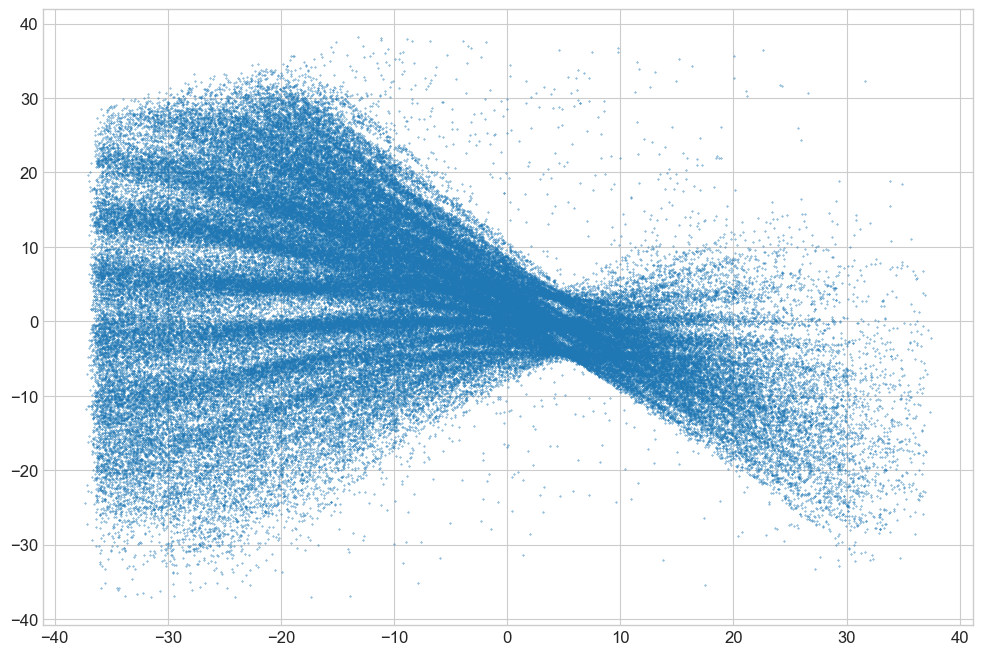

In [8]:
#plt.hist(df.P_react_z, bins=100, range=(-50, 50))
cond = (df.P_react_z > -10) & (df.P_react_z < 10)
plt.scatter(df.P_dc_x_fp[cond], df.P_dc_y_fp[cond], s=0.1)

(-5.0, 5.0)

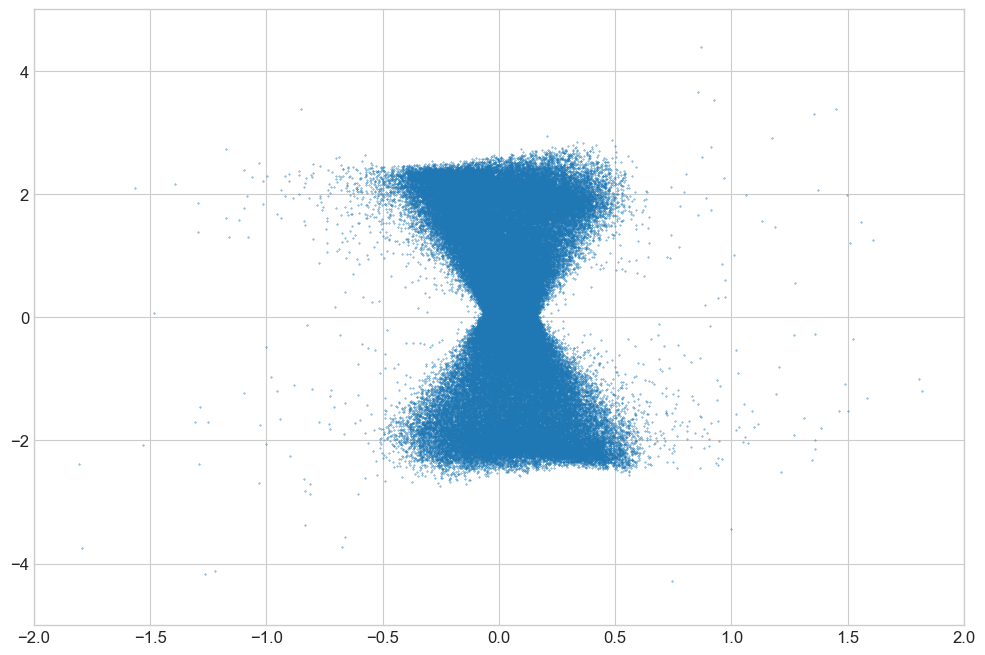

In [9]:
plt.scatter(df.P_gtr_x[cond], df.P_gtr_y[cond], s=0.1)
plt.xlim(-2, 2)
plt.ylim(-5, 5)


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(200, 200)),
 array([-20. , -19.8, -19.6, -19.4, -19.2, -19. , -18.8, -18.6, -18.4,
        -18.2, -18. , -17.8, -17.6, -17.4, -17.2, -17. , -16.8, -16.6,
        -16.4, -16.2, -16. , -15.8, -15.6, -15.4, -15.2, -15. , -14.8,
        -14.6, -14.4, -14.2, -14. , -13.8, -13.6, -13.4, -13.2, -13. ,
        -12.8, -12.6, -12.4, -12.2, -12. , -11.8, -11.6, -11.4, -11.2,
        -11. , -10.8, -10.6, -10.4, -10.2, -10. ,  -9.8,  -9.6,  -9.4,
         -9.2,  -9. ,  -8.8,  -8.6,  -8.4,  -8.2,  -8. ,  -7.8,  -7.6,
         -7.4,  -7.2,  -7. ,  -6.8,  -6.6,  -6.4,  -6.2,  -6. ,  -5.8,
         -5.6,  -5.4,  -5.2,  -5. ,  -4.8,  -4.6,  -4.4,  -4.2,  -4. ,
         -3.8,  -3.6,  -3.4,  -3.2,  -3. ,  -2.8,  -2.6,  -2.4,  -2.2,
         -2. ,  -1.8,  

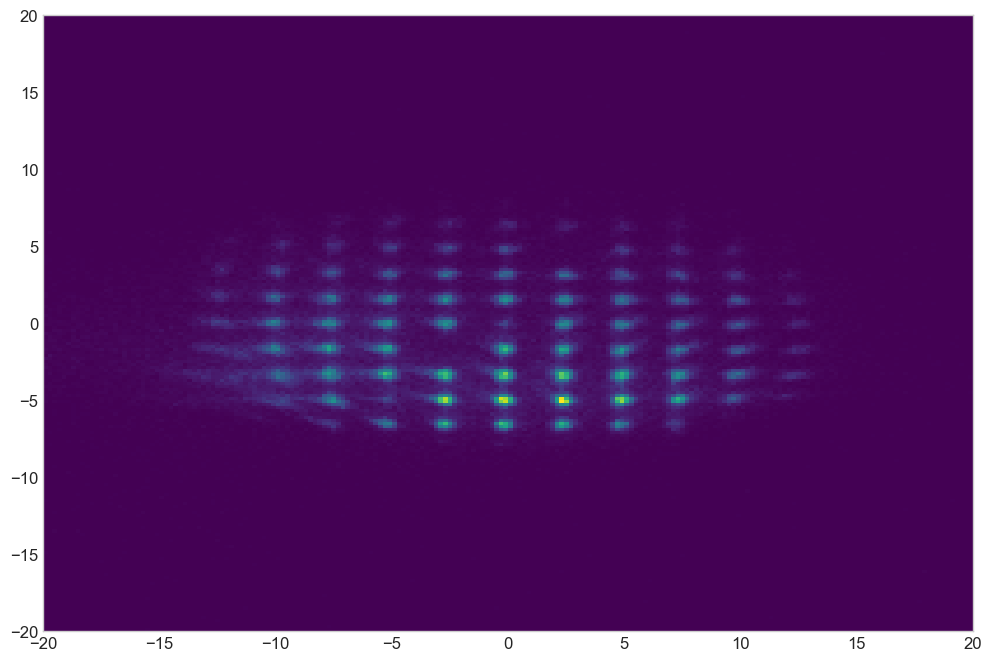

In [12]:
x = df.P_gtr_x
y = df.P_gtr_y
th = df.P_gtr_th
dp = df.P_gtr_dp
ph = df.P_gtr_ph
def project_to_target(x,y,th,ph,dp):
    Target_x = x+th*253.0
    Target_y = (-0.019*dp+0.00019*dp**2+(138.0+75.0)*ph+y) + 40.0*(-0.00052*dp+0.0000052*dp**2+ph)
    return (Target_x,Target_y)
plt.hist2d(project_to_target(x,y,th,ph,dp)[0],project_to_target(x,y,th,ph,dp)[1], bins=200, range=[[-20, 20], [-20, 20]], cmap='viridis')

In [23]:
# ============================================================
# 2.2 Data Statistical Summary
# ============================================================

# Display first few rows
print("=== Data Preview ===")
display(df.head(10))

# Statistical summary
print("\n=== Statistical Summary ===")
display(df.describe())

=== Data Preview ===


,P_gtr_x,P_gtr_y,P_gtr_dp,P_gtr_p,P_gtr_ph,P_gtr_th,P_gtr_beta,P_gtr_index,P_dc_x_fp,P_dc_y_fp,...,P_react_y,P_react_z,P_kin_x_bj,P_kin_Q2,P_kin_nu,P_kin_W,P_rb_raster_frxaRawAdc,P_rb_raster_frxbRawAdc,P_rb_raster_fryaRawAdc,P_rb_raster_frybRawAdc
0,0.267826,-0.803207,-9.059419,5.758874,-0.019570,-0.038476,0.967591,0.0,-9.017416,17.520059,...,-0.024574,3.094540,0.319436,2.944861,4.912726,2.674774,59309.0,59667.0,67546.0,67847.0
1,1.302476,-4.917810,-16.488476,5.288424,0.012637,-0.058877,1.031335,0.0,-23.649050,-10.722626,...,0.067639,22.022441,0.360747,3.644172,5.383176,2.708860,45626.0,45116.0,56029.0,56651.0
2,0.378030,2.416124,-1.440020,6.241378,-0.004373,0.026959,1.007104,0.0,-3.791826,-4.526428,...,0.017517,-10.552505,0.432827,3.598306,4.430222,2.365488,60986.0,61029.0,62289.0,62405.0
3,-0.201874,1.792566,-19.805738,5.078356,-0.007210,-0.032995,0.935665,0.0,-32.469074,-7.858502,...,0.095846,-7.531929,0.273495,2.870584,5.593244,2.916455,53051.0,53234.0,52506.0,53142.0
4,-0.101487,1.162009,-14.182369,5.434460,0.015956,-0.023892,0.000000,0.0,-20.282001,-28.538797,...,0.119081,-4.768102,0.374758,3.683008,5.237140,2.650480,58998.0,59138.0,49604.0,50050.0
5,0.034265,-0.538418,10.383965,6.990140,-0.007989,-0.001596,0.972776,0.0,15.322555,-4.533657,...,0.095638,2.503758,0.557437,3.850999,3.681460,1.984379,58579.0,58981.0,52532.0,52330.0
6,0.136701,0.097255,-4.906000,6.021892,-0.020283,-0.021454,0.978964,0.0,-5.845677,9.363089,...,-0.023005,-0.591048,0.343474,2.996935,4.649708,2.570754,56272.0,56067.0,67350.0,67496.0
7,0.255576,-1.572379,8.233274,6.853946,0.008923,-0.038074,0.857087,0.0,10.098772,2.158332,...,0.137505,7.054343,0.621187,4.450171,3.817654,1.895827,45467.0,45052.0,47303.0,47428.0
8,-0.041639,-1.136746,-10.522147,5.666246,-0.017750,0.007738,0.974669,0.0,-20.651463,16.957997,...,0.126736,5.314595,0.305141,2.866110,5.005354,2.721578,65050.0,65341.0,48648.0,48360.0
9,0.226384,-2.626689,-0.800627,6.281868,-0.010113,-0.016856,1.062261,0.0,-0.133116,7.262270,...,0.101042,11.826848,0.414140,3.411483,4.389732,2.388802,46551.0,46410.0,51857.0,51888.0



=== Statistical Summary ===


,P_gtr_x,P_gtr_y,P_gtr_dp,P_gtr_p,P_gtr_ph,P_gtr_th,P_gtr_beta,P_gtr_index,P_dc_x_fp,P_dc_y_fp,...,P_react_y,P_react_z,P_kin_x_bj,P_kin_Q2,P_kin_nu,P_kin_W,P_rb_raster_frxaRawAdc,P_rb_raster_frxbRawAdc,P_rb_raster_fryaRawAdc,P_rb_raster_frybRawAdc
count,249193.000000,249193.000000,249193.000000,249193.000000,249193.000000,249193.000000,249193.000000,249193.000000,249193.000000,249193.000000,...,249193.000000,249193.000000,249193.000000,249193.000000,249193.000000,2.491930e+05,249193.000000,249193.000000,249193.000000,249193.000000
mean,0.245848,0.331832,-6.596932,5.914813,-0.010343,-0.007922,0.986618,0.968089,-11.003769,3.344575,...,0.079945,-2.700131,0.389906,3.347357,4.756787,3.952760e+35,54364.245625,54371.804316,54627.054291,54767.114831
std,3.233927,10.427041,10.105997,0.639969,0.052784,0.047988,0.163075,6.532324,16.190524,13.121736,...,0.061131,63.018722,0.230302,1.577450,0.639969,6.274672e+36,7244.624064,7457.434545,7632.713561,7483.355875
min,-84.702303,-1416.084801,-29.996394,4.433026,-10.029908,-10.004451,0.000000,0.000000,-38.637804,-38.689076,...,-0.032380,-27395.257207,0.000090,0.000572,2.439425,6.711802e-02,41664.000000,41254.000000,41494.000000,41234.000000
25%,-0.130458,-1.055386,-13.916027,5.451326,-0.022333,-0.029503,0.964631,0.000000,-24.293530,-4.955569,...,0.026857,-10.865116,0.294179,2.825051,4.370911,2.341588e+00,48100.000000,47850.000000,47978.000000,48256.000000
50%,0.031552,0.723753,-8.442197,5.797960,-0.012200,-0.007718,1.000767,0.000000,-12.934463,2.416949,...,0.080245,-2.982247,0.354400,3.210866,4.873640,2.607026e+00,54369.000000,54371.000000,54590.000000,54741.000000
75%,0.173634,2.473257,-0.503407,6.300689,-0.000388,0.016467,1.040996,0.000000,0.494481,12.053688,...,0.133176,4.933392,0.441443,3.640991,5.220274,2.786049e+00,60642.000000,60894.000000,61261.000000,61253.000000
max,150.432584,1280.650886,29.997412,8.232174,5.547274,7.786710,2.961573,99.000000,39.517868,41.287079,...,0.197079,1173.551124,22.950534,155.737624,6.238574,1.000000e+38,66978.000000,67455.000000,67813.000000,68447.000000


In [4]:
# ============================================================
# 2.3 Check Missing Values and Data Types
# ============================================================

print("=== Missing Values Check ===")
missing_info = pd.DataFrame({
    'Data Type': df.dtypes,
    'Non-null Count': df.count(),
    'Missing Values': df.isnull().sum(),
    'Missing Rate (%)': (df.isnull().sum() / len(df) * 100).round(2)
})
display(missing_info)

# Check for infinite values
print("\n=== Infinite Values Check ===")
inf_counts = np.isinf(df.select_dtypes(include=[np.number])).sum()
print(inf_counts[inf_counts > 0] if inf_counts.sum() > 0 else "No infinite values")

=== Missing Values Check ===


,Data Type,Non-null Count,Missing Values,Missing Rate (%)
P_gtr_x,float64,249193,0,0.0
P_gtr_y,float64,249193,0,0.0
P_gtr_dp,float64,249193,0,0.0
P_gtr_p,float64,249193,0,0.0
P_gtr_ph,float64,249193,0,0.0
P_gtr_th,float64,249193,0,0.0
P_gtr_beta,float64,249193,0,0.0
P_gtr_index,float64,249193,0,0.0
P_dc_x_fp,float64,249193,0,0.0
P_dc_y_fp,float64,249193,0,0.0



=== Infinite Values Check ===
No infinite values


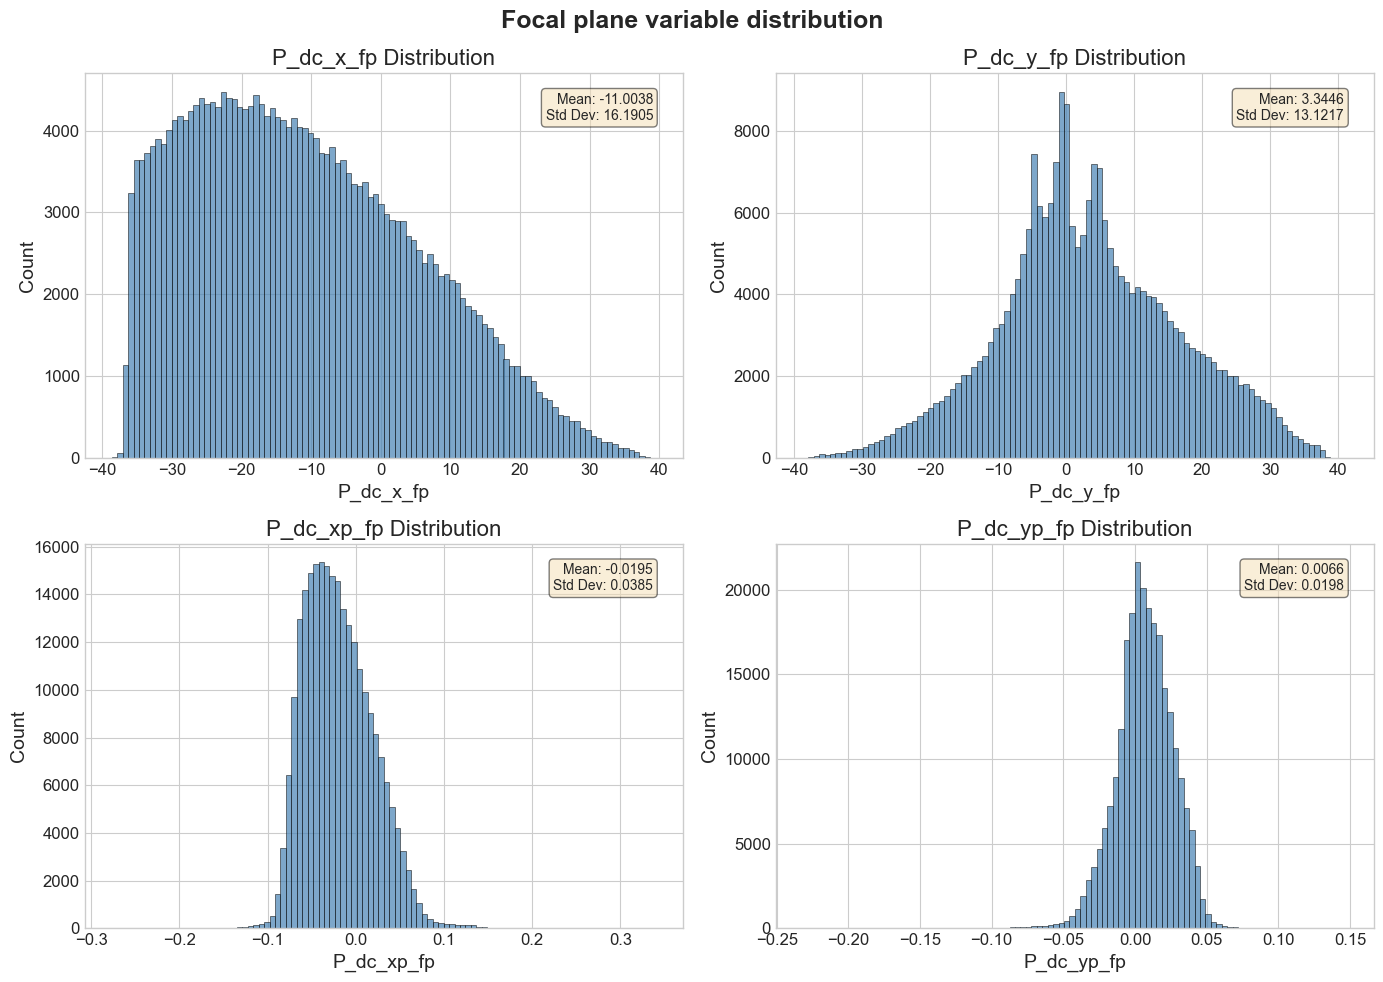

In [5]:
# ============================================================
# 2.4 Focal Plane Variable Distribution Visualization
# ============================================================

# Define focal plane variables
focal_plane_vars = ['P_dc_x_fp', 'P_dc_y_fp', 'P_dc_xp_fp', 'P_dc_yp_fp']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, var in enumerate(focal_plane_vars):
    ax = axes[i]
    data = df[var].dropna()
    
    # Plot histogram
    ax.hist(data, bins=100, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
    ax.set_xlabel(var)
    ax.set_ylabel('Count')
    ax.set_title(f'{var} Distribution')
    
    # Add statistics
    stats_text = f'Mean: {data.mean():.4f}\nStd Dev: {data.std():.4f}'
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Focal plane variable distribution', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

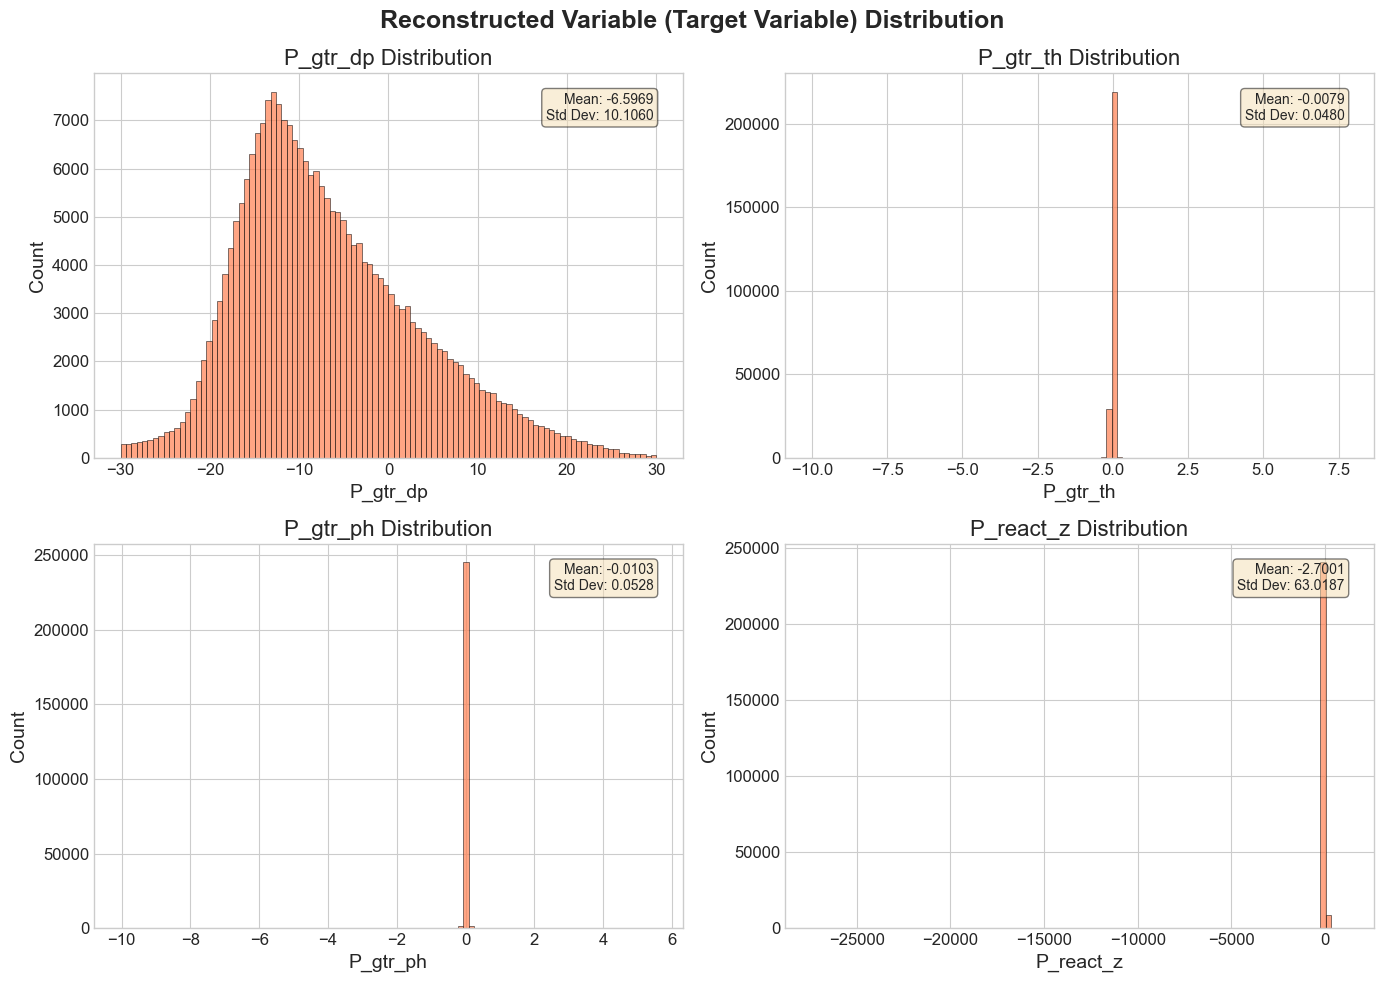

In [6]:
# ============================================================
# 2.5 Reconstructed Variable (Target Variable) Distribution Visualization
# ============================================================

# Define target variables
target_vars = ['P_gtr_dp', 'P_gtr_th', 'P_gtr_ph', 'P_react_z']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, var in enumerate(target_vars):
    ax = axes[i]
    data = df[var].dropna()
    
    # Plot histogram
    ax.hist(data, bins=100, color='coral', alpha=0.7, edgecolor='black', linewidth=0.5)
    ax.set_xlabel(var)
    ax.set_ylabel('Count')
    ax.set_title(f'{var} Distribution')
    
    # Add statistics
    stats_text = f'Mean: {data.mean():.4f}\nStd Dev: {data.std():.4f}'
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Reconstructed Variable (Target Variable) Distribution', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

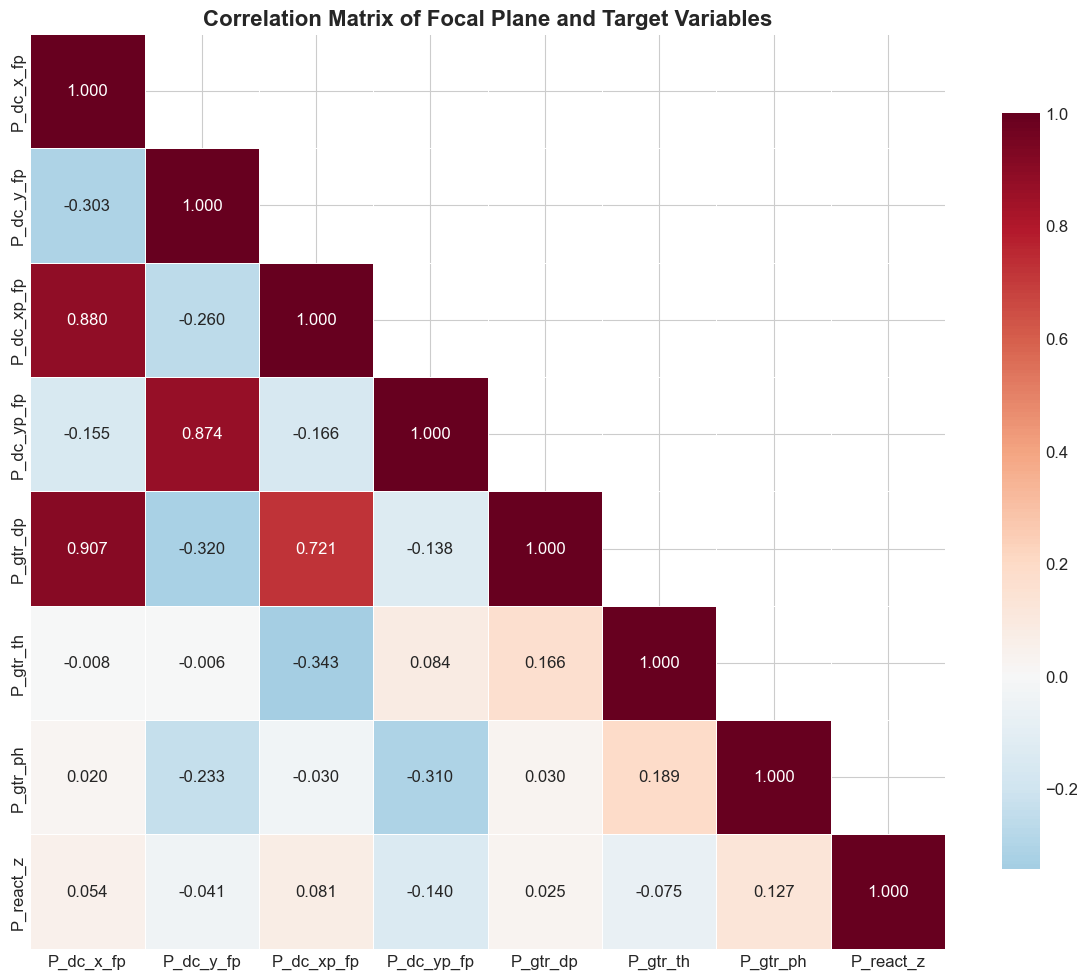


=== Correlation Analysis Conclusion ===
Main correlations between focal plane and target variables:

P_gtr_dp:
  P_dc_x_fp: 0.907
  P_dc_y_fp: -0.320
  P_dc_xp_fp: 0.721
  P_dc_yp_fp: -0.138

P_gtr_th:
  P_dc_x_fp: -0.008
  P_dc_y_fp: -0.006
  P_dc_xp_fp: -0.343
  P_dc_yp_fp: 0.084

P_gtr_ph:
  P_dc_x_fp: 0.020
  P_dc_y_fp: -0.233
  P_dc_xp_fp: -0.030
  P_dc_yp_fp: -0.310

P_react_z:
  P_dc_x_fp: 0.054
  P_dc_y_fp: -0.041
  P_dc_xp_fp: 0.081
  P_dc_yp_fp: -0.140


In [7]:
# ============================================================
# 2.6 Focal Plane Variable Correlation Analysis
# ============================================================

# Select variables for correlation analysis
correlation_vars = focal_plane_vars + target_vars

# Calculate correlation matrix
corr_matrix = df[correlation_vars].corr()

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            fmt='.3f', 
            cmap='RdBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.8},
            ax=ax)

ax.set_title('Correlation Matrix of Focal Plane and Target Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n=== Correlation Analysis Conclusion ===")
print("Main correlations between focal plane and target variables:")
for target in target_vars:
    print(f"\n{target}:")
    for fp in focal_plane_vars:
        corr = corr_matrix.loc[fp, target]
        print(f"  {fp}: {corr:.3f}")

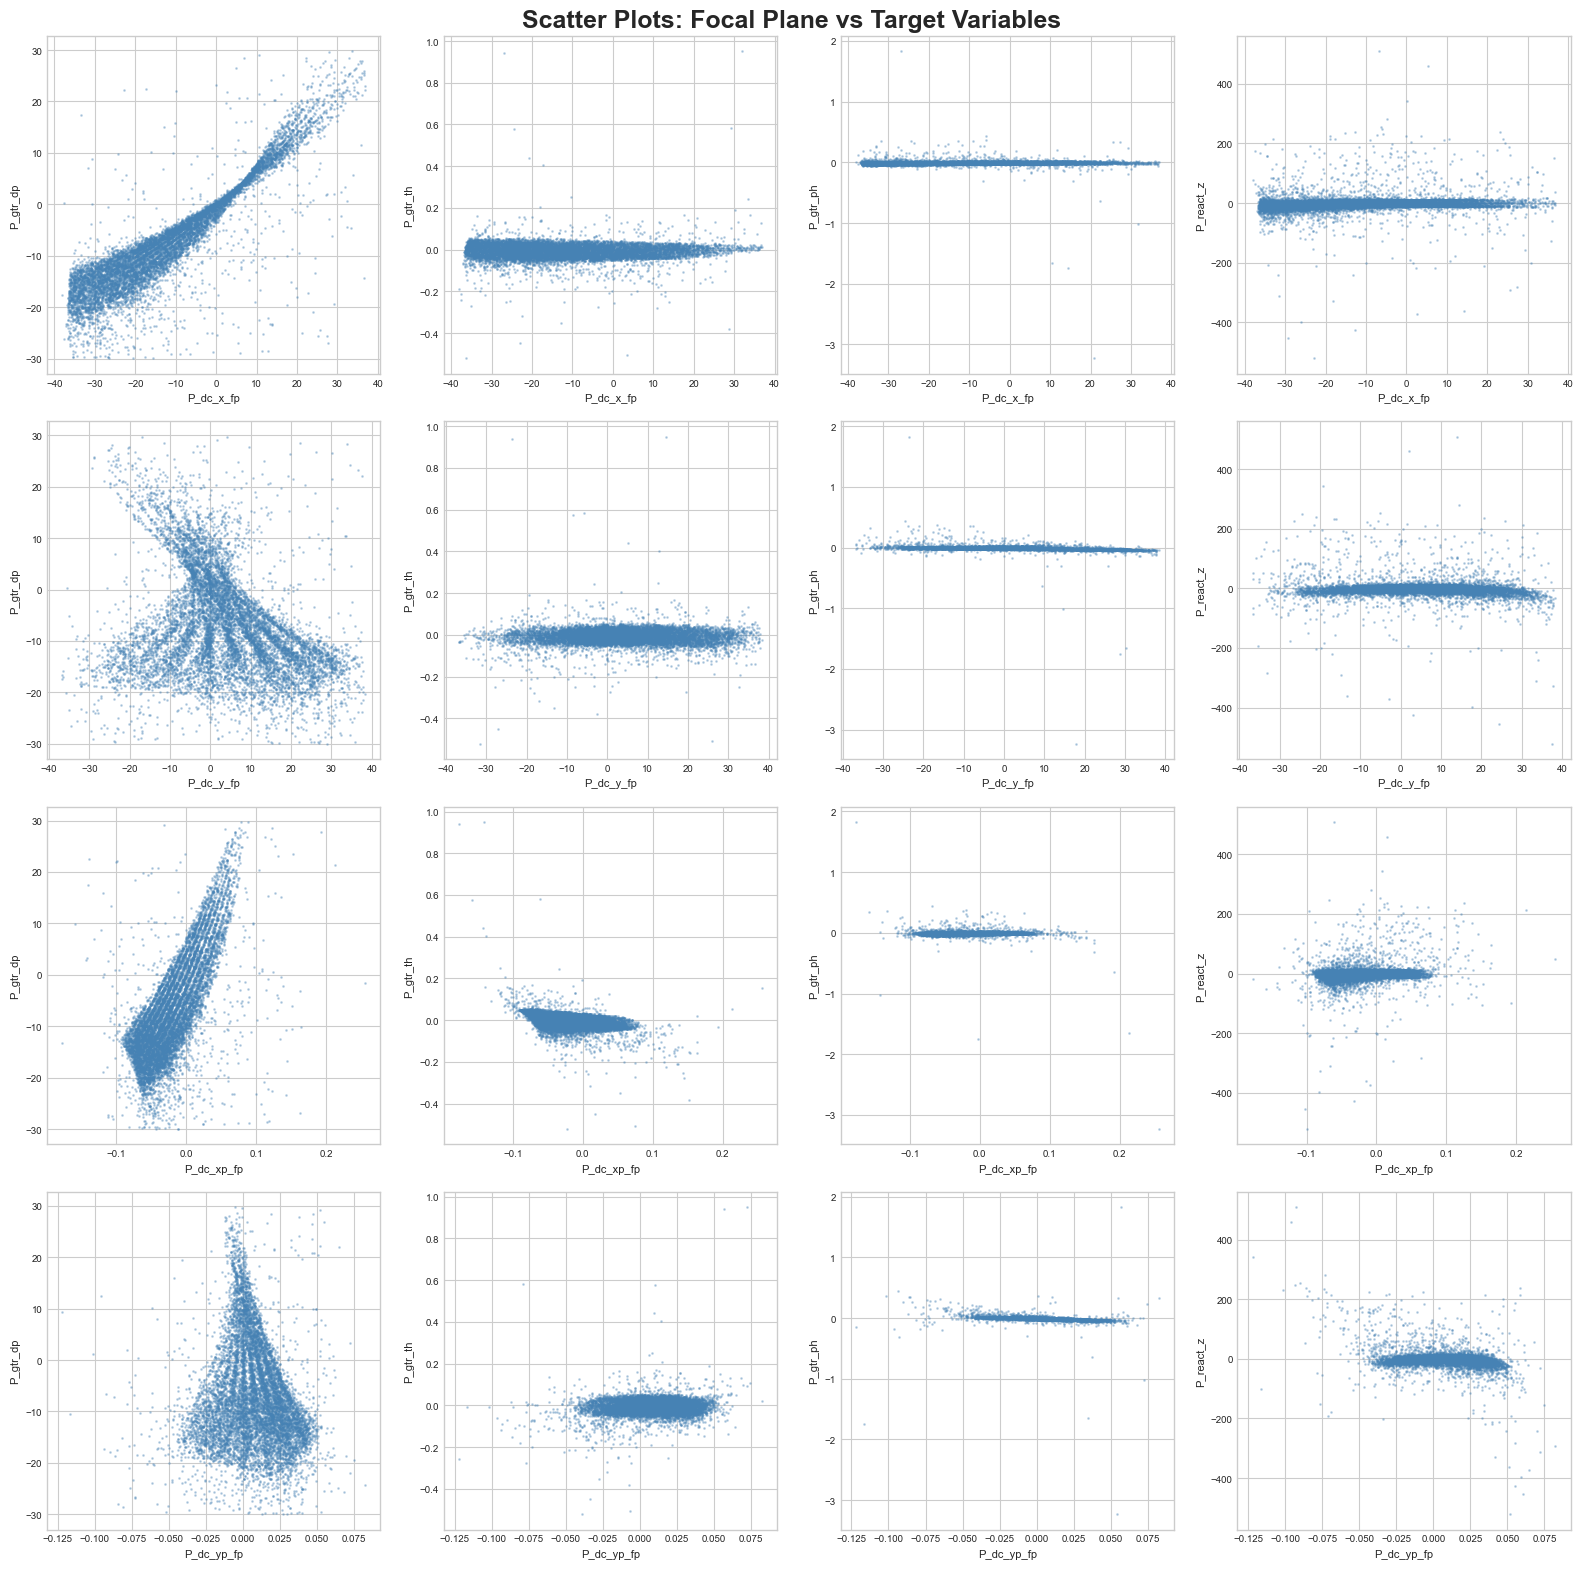

In [8]:
# ============================================================
# 2.7 2D Scatter Plots: Focal Plane vs Target Variables
# ============================================================

fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# Sample display (avoid too many points affecting visualization)
sample_size = min(10000, len(df))
df_sample = df.sample(n=sample_size, random_state=RANDOM_SEED)

for i, fp_var in enumerate(focal_plane_vars):
    for j, target in enumerate(target_vars):
        ax = axes[i, j]
        ax.scatter(df_sample[fp_var], df_sample[target], 
                   alpha=0.3, s=1, c='steelblue')
        ax.set_xlabel(fp_var, fontsize=8)
        ax.set_ylabel(target, fontsize=8)
        ax.tick_params(labelsize=7)

plt.suptitle('Scatter Plots: Focal Plane vs Target Variables', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Data Preprocessing / 数据预处理

Prepare the data for machine learning:
- **3.1** Define input features (focal plane) and target variables (reconstructed)
- **3.2** Clean data: remove NaN and infinite values
- **3.3** Split dataset: 60% train / 20% validation / 20% test
- **3.4** Feature scaling using StandardScaler (z-score normalization)

为机器学习准备数据：
- **3.1** 定义输入特征（焦平面变量）和目标变量（重建变量）
- **3.2** 数据清洗：移除 NaN 和无穷值
- **3.3** 数据集划分：60% 训练 / 20% 验证 / 20% 测试
- **3.4** 使用 StandardScaler 进行特征缩放（z-score 归一化）

In [4]:
# ============================================================
# 3.1 Define Input Features and Target Variables
# ============================================================

# Input features: Focal plane variables
FEATURE_COLS = ['P_dc_x_fp', 'P_dc_y_fp', 'P_dc_xp_fp', 'P_dc_yp_fp']

# Target variables: Reconstructed variables
TARGET_COLS = ['P_gtr_dp', 'P_gtr_th', 'P_gtr_ph', 'P_react_z']

# Extract features and targets
X = df[FEATURE_COLS].copy()
y = df[TARGET_COLS].copy()

print(f"Input Features X Shape: {X.shape}")
print(f"Target Variables y Shape: {y.shape}")
print(f"\nInput Features: {FEATURE_COLS}")
print(f"Target Variables: {TARGET_COLS}")

Input Features X Shape: (249193, 4)
Target Variables y Shape: (249193, 4)

Input Features: ['P_dc_x_fp', 'P_dc_y_fp', 'P_dc_xp_fp', 'P_dc_yp_fp']
Target Variables: ['P_gtr_dp', 'P_gtr_th', 'P_gtr_ph', 'P_react_z']


In [5]:
# ============================================================
# 3.2 Data Cleaning: Handle Missing and Outlier Values
# ============================================================

# Concatenate X and y for unified processing
data = pd.concat([X, y], axis=1)

# Remove rows containing NaN or Inf
original_len = len(data)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()
cleaned_len = len(data)

print(f"Original Data Size: {original_len:,}")
print(f"Cleaned Data Size: {cleaned_len:,}")
print(f"Removed Data Size: {original_len - cleaned_len:,} ({(original_len - cleaned_len) / original_len * 100:.2f}%)")

# Separate X and y again
X_clean = data[FEATURE_COLS]
y_clean = data[TARGET_COLS]

Original Data Size: 249,193
Cleaned Data Size: 249,193
Removed Data Size: 0 (0.00%)


In [6]:
# ============================================================
# 3.3 Dataset Splitting: Train / Validation / Test
# ============================================================

# First split into Train+Val and Test (80% / 20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=RANDOM_SEED
)

# Then split Train+Val into Train and Validation (75% / 25% => Overall 60% / 20% / 20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=RANDOM_SEED
)

print("=== Dataset Splitting ===")
print(f"Training Set: {len(X_train):,} samples ({len(X_train)/len(X_clean)*100:.1f}%)")
print(f"Validation Set: {len(X_val):,} samples ({len(X_val)/len(X_clean)*100:.1f}%)")
print(f"Test Set: {len(X_test):,} samples ({len(X_test)/len(X_clean)*100:.1f}%)")
print(f"Total: {len(X_clean):,} samples")

=== Dataset Splitting ===
Training Set: 149,515 samples (60.0%)
Validation Set: 49,839 samples (20.0%)
Test Set: 49,839 samples (20.0%)
Total: 249,193 samples


In [7]:
# ============================================================
# 3.4 Feature Scaling
# ============================================================

# Initialize StandardScaler (fit on training set)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale features
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Scale target variables (for neural network training)
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

print("=== Feature Scaling Parameters ===")
print("\nInput Features (X):")
for i, col in enumerate(FEATURE_COLS):
    print(f"  {col}: Mean={scaler_X.mean_[i]:.6f}, Std Dev={scaler_X.scale_[i]:.6f}")

print("\nTarget Variables (y):")
for i, col in enumerate(TARGET_COLS):
    print(f"  {col}: Mean={scaler_y.mean_[i]:.6f}, Std Dev={scaler_y.scale_[i]:.6f}")

=== Feature Scaling Parameters ===

Input Features (X):
  P_dc_x_fp: Mean=-11.004696, Std Dev=16.188238
  P_dc_y_fp: Mean=3.358272, Std Dev=13.132058
  P_dc_xp_fp: Mean=-0.019521, Std Dev=0.038553
  P_dc_yp_fp: Mean=0.006659, Std Dev=0.019837

Target Variables (y):
  P_gtr_dp: Mean=-6.595262, Std Dev=10.092842
  P_gtr_th: Mean=-0.007936, Std Dev=0.052340
  P_gtr_ph: Mean=-0.010413, Std Dev=0.054278
  P_react_z: Mean=-2.763147, Std Dev=77.457211


## 4. Evaluation Metrics / 评估指标

Define functions to evaluate model performance:
- **MSE** (Mean Squared Error): Average squared difference
- **RMSE** (Root MSE): Interpretable error in original units
- **MAE** (Mean Absolute Error): Robust to outliers
- **R²** (Coefficient of Determination): Explained variance ratio

定义模型性能评估函数：
- **MSE**（均方误差）：平均平方差
- **RMSE**（均方根误差）：原始单位的可解释误差
- **MAE**（平均绝对误差）：对异常值鲁棒
- **R²**（决定系数）：解释方差比例

In [8]:
# ============================================================
# 4.1 Define Evaluation Function
# ============================================================

def evaluate_model(y_true, y_pred, target_names=TARGET_COLS):
    """
    Evaluate model performance
    
    Args:
        y_true: True values
        y_pred: Predicted values
        target_names: List of target variable names
    
    Returns:
        metrics_df: DataFrame containing evaluation metrics for each target variable
    """
    metrics = []
    
    for i, name in enumerate(target_names):
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        
        metrics.append({
            'Variable': name,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2
        })
    
    return pd.DataFrame(metrics)

def plot_residuals(y_true, y_pred, target_names=TARGET_COLS, title_prefix=""):
    """
    Plot residual distribution
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for i, name in enumerate(target_names):
        ax = axes[i]
        residuals = y_true[:, i] - y_pred[:, i]
        
        ax.hist(residuals, bins=100, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
        ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
        ax.set_xlabel(f'Residual ({name})')
        ax.set_ylabel('Count')
        ax.set_title(f'{title_prefix}{name} Residual Distribution')
        
        # Add statistics
        stats_text = f'Mean: {residuals.mean():.2e}\nStd Dev: {residuals.std():.2e}'
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

print("✅ Evaluation function defined")

✅ Evaluation function defined


📊 焦平面数据聚类分析 - 识别靶上空洞位置
   Clustering on Focal Plane Data Only

输入特征: ['P_dc_x_fp', 'P_dc_y_fp', 'P_dc_xp_fp', 'P_dc_yp_fp']
数据点数: 249,193

使用 K-Means 聚类 (k=87)...
  (对应多孔板 87 个孔洞)
聚类完成!
聚类完成!


/var/folders/7c/kwhn06r91h57xlqx9rqvvpmm0000gn/T/ipykernel_7493/1235193785.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_clusters)  # 或使用 'nipy_spectral', 'hsv'


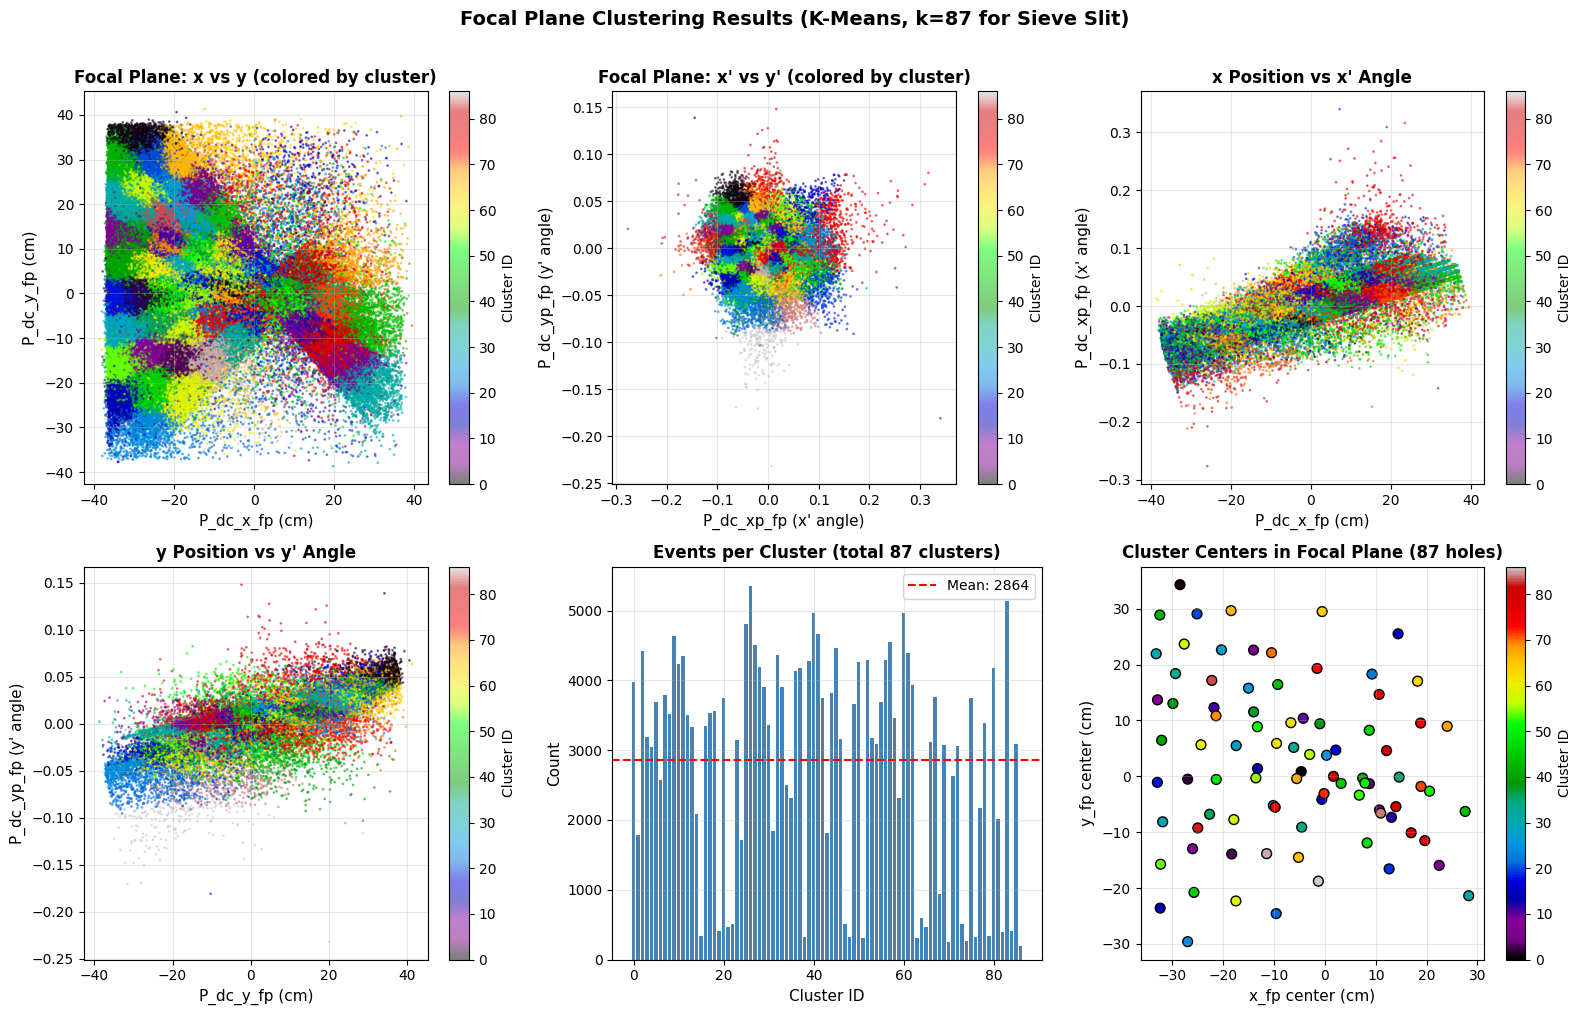


📍 聚类结果统计 (87 个孔洞)

每个聚类的事件数:
  最小: 188
  最大: 5,360
  平均: 2864.3
  中位数: 3352.0
  标准差: 1546.9

前10个最大聚类:
  Cluster 26: 5,360 events (2.2%)
  Cluster 83: 5,138 events (2.1%)
  Cluster 40: 4,971 events (2.0%)
  Cluster 60: 4,961 events (2.0%)
  Cluster 25: 4,812 events (1.9%)
  Cluster 41: 4,672 events (1.9%)
  Cluster 9: 4,638 events (1.9%)
  Cluster 57: 4,554 events (1.8%)
  Cluster 27: 4,509 events (1.8%)
  Cluster 45: 4,463 events (1.8%)

✅ 聚类完成! 基于焦平面数据识别出 87 个聚类
   这些聚类可能对应靶上不同的空洞位置


In [4]:
# ============================================================
# 16.6 焦平面数据聚类分析 - 识别靶上空洞
# Clustering Analysis on Focal Plane Data - Identify Target Foils
# ============================================================
# 注意：只使用焦平面测量值，不使用任何 react 变量

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

os.makedirs('plots', exist_ok=True)

print("="*70)
print("📊 焦平面数据聚类分析 - 识别靶上空洞位置")
print("   Clustering on Focal Plane Data Only")
print("="*70)

# 加载数据
ROOT_FILE_PATH = "RootData/skimmed_shms_coin_replay_production_25521_-1.root"
TREE_NAME = "T"

if 'data' not in dir() or data is None:
    print("\n正在加载 ROOT 数据...")
    root_file = uproot.open(ROOT_FILE_PATH)
    tree = root_file[TREE_NAME]
    data = tree.arrays(library="pd")
    print(f"加载完成: {len(data):,} 事件")

# 只使用焦平面测量值作为输入
FOCAL_PLANE_COLS = ['P_dc_x_fp', 'P_dc_y_fp', 'P_dc_xp_fp', 'P_dc_yp_fp']
X_fp = data[FOCAL_PLANE_COLS].copy()

# 标准化
scaler = StandardScaler()
X_fp_scaled = scaler.fit_transform(X_fp)

print(f"\n输入特征: {FOCAL_PLANE_COLS}")
print(f"数据点数: {len(X_fp):,}")

# ========== 使用 K-Means 聚类 (多孔板有 87 个孔洞) ==========
n_clusters = 87  # 多孔板 (sieve slit) 的孔洞数量

print(f"\n使用 K-Means 聚类 (k={n_clusters})...")
print("  (对应多孔板 87 个孔洞)")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=500)
cluster_labels = kmeans.fit_predict(X_fp_scaled)

print("聚类完成!")

# ========== 可视化聚类结果 ==========
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 使用 colormap 为 87 个聚类生成颜色
cmap = plt.cm.get_cmap('tab20', n_clusters)  # 或使用 'nipy_spectral', 'hsv'

# 1. x_fp vs y_fp - 按聚类着色
ax = axes[0, 0]
scatter = ax.scatter(X_fp.iloc[:, 0], X_fp.iloc[:, 1], 
                     c=cluster_labels, cmap='nipy_spectral', alpha=0.5, s=1)
ax.set_xlabel('P_dc_x_fp (cm)', fontsize=11)
ax.set_ylabel('P_dc_y_fp (cm)', fontsize=11)
ax.set_title('Focal Plane: x vs y (colored by cluster)', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Cluster ID')
ax.grid(True, alpha=0.3)

# 2. xp_fp vs yp_fp (角度) - 按聚类着色
ax = axes[0, 1]
scatter = ax.scatter(X_fp.iloc[:, 2], X_fp.iloc[:, 3], 
                     c=cluster_labels, cmap='nipy_spectral', alpha=0.5, s=1)
ax.set_xlabel("P_dc_xp_fp (x' angle)", fontsize=11)
ax.set_ylabel("P_dc_yp_fp (y' angle)", fontsize=11)
ax.set_title("Focal Plane: x' vs y' (colored by cluster)", fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Cluster ID')
ax.grid(True, alpha=0.3)

# 3. x_fp vs xp_fp - 按聚类着色
ax = axes[0, 2]
scatter = ax.scatter(X_fp.iloc[:, 0], X_fp.iloc[:, 2], 
                     c=cluster_labels, cmap='nipy_spectral', alpha=0.5, s=1)
ax.set_xlabel('P_dc_x_fp (cm)', fontsize=11)
ax.set_ylabel("P_dc_xp_fp (x' angle)", fontsize=11)
ax.set_title("x Position vs x' Angle", fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Cluster ID')
ax.grid(True, alpha=0.3)

# 4. y_fp vs yp_fp - 按聚类着色
ax = axes[1, 0]
scatter = ax.scatter(X_fp.iloc[:, 1], X_fp.iloc[:, 3], 
                     c=cluster_labels, cmap='nipy_spectral', alpha=0.5, s=1)
ax.set_xlabel('P_dc_y_fp (cm)', fontsize=11)
ax.set_ylabel("P_dc_yp_fp (y' angle)", fontsize=11)
ax.set_title("y Position vs y' Angle", fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Cluster ID')
ax.grid(True, alpha=0.3)

# 5. 聚类大小分布
ax = axes[1, 1]
cluster_counts = np.bincount(cluster_labels)
ax.bar(range(n_clusters), cluster_counts, color='steelblue', edgecolor='none')
ax.set_xlabel('Cluster ID', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title(f'Events per Cluster (total {n_clusters} clusters)', fontsize=12, fontweight='bold')
ax.axhline(np.mean(cluster_counts), color='red', linestyle='--', 
           label=f'Mean: {np.mean(cluster_counts):.0f}')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. 聚类中心在 x_fp-y_fp 空间中的位置
ax = axes[1, 2]
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
scatter = ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], 
                     c=range(n_clusters), cmap='nipy_spectral', s=50, edgecolors='black')
ax.set_xlabel('x_fp center (cm)', fontsize=11)
ax.set_ylabel('y_fp center (cm)', fontsize=11)
ax.set_title(f'Cluster Centers in Focal Plane ({n_clusters} holes)', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Cluster ID')
ax.grid(True, alpha=0.3)

plt.suptitle(f'Focal Plane Clustering Results (K-Means, k={n_clusters} for Sieve Slit)', 
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('plots/focal_plane_clustering_87holes.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== 聚类统计 ==========
print("\n" + "="*70)
print("📍 聚类结果统计 (87 个孔洞)")
print("="*70)

# 只显示统计摘要，不显示全部87行
cluster_counts = np.bincount(cluster_labels)
print(f"\n每个聚类的事件数:")
print(f"  最小: {cluster_counts.min():,}")
print(f"  最大: {cluster_counts.max():,}")
print(f"  平均: {cluster_counts.mean():.1f}")
print(f"  中位数: {np.median(cluster_counts):.1f}")
print(f"  标准差: {cluster_counts.std():.1f}")

# 显示前10个最大的聚类
top10_idx = np.argsort(cluster_counts)[-10:][::-1]
print(f"\n前10个最大聚类:")
for idx in top10_idx:
    print(f"  Cluster {idx}: {cluster_counts[idx]:,} events ({cluster_counts[idx]/len(cluster_labels)*100:.1f}%)")

print(f"\n✅ 聚类完成! 基于焦平面数据识别出 {n_clusters} 个聚类")
print("   这些聚类可能对应靶上不同的空洞位置")